In [1]:
!pip install -q git+https://github.com/tensorflow/docs 

In [39]:
import tensorflow
import pandas as pd
import time
import numpy as np

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import numpy as np
import pylab as plt
import multiprocessing as mp

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part A: Classifications

# Read Data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/NTU/CZ4042-Assignment-1/dataset/features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [3]:
df['label'].value_counts()

disco        100
reggae       100
metal        100
classical    100
pop          100
country      100
rock         100
blues        100
hiphop       100
jazz         100
Name: label, dtype: int64

In [4]:
columns_to_drop = ['label','filename', 'length']

def prepare_dataset(df, columns_to_drop, test_size, random_state):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # devide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    # scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test


Import training modules. Split and scale dataset.

In [5]:
X_train, Y_train, X_test, Y_test = prepare_dataset(df, columns_to_drop, test_size=0.3, random_state=0)
Y_train = tf.keras.utils.to_categorical(Y_train)
Y_test = tf.keras.utils.to_categorical(Y_test)


In [6]:
histories = {}

## Model

In [23]:
class Timekeeper (keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def train_model(model, lr = 0.001, batch_size = 1, epochs = 50, verbose = 2, x_train = X_train, y_train = Y_train, x_test = X_test, y_test = Y_test):
    time_callback = Timekeeper()

    model.compile(optimizer = Adam(learning_rate = lr),
                                loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                metrics = [tf.keras.losses.CategoricalCrossentropy(from_logits=True, name = 'ce'),
                                'accuracy'])
                                
    history = model.fit(x_train, y_train,
                        batch_size = batch_size,
                        epochs = 50, 
                        verbose = 2,
                        callbacks=[
                                  #  tf.keras.callbacks.EarlyStopping(monitor='val_ce', patience=20),
                                    tfdocs.modeling.EpochDots(), time_callback],
                        validation_data=(x_test, y_test)
                        )
    
    return history, time_callback.times

def test_model(model, X_test = X_test, Y_test = Y_test, batch_size = 1):
  results = model.evaluate(X_test, Y_test, batch_size)
  return results

# Q1

Design a feedforward deep neural network (DNN) which consists of an input layer, one
hidden layer of 16 neurons with ReLU activation function, and an output softmax layer.
Use an stochastic gradient descent with ‘adam’ optimizer with default parameters, and
batch size = 1. Apply dropout of probability 0.3 to the hidden layer.
Divide the dataset into a 70:30 ratio for training and testing. Use appropriate scaling of
input features. We solely assume that there are only two datasets here: training & test.
We would look into validation in Question 2 onwards.

## Q1.a

Use the training dataset to train the model for 50 epochs. Note: Use 50
epochs for subsequent experiments.

In [24]:
model = Sequential([
                Dense(16, activation='relu'),
                Dropout(rate = 0.3),
                Dense(10, activation='softmax')
            ])

histories['q1_history'], _ = train_model(model)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


700/700 - 3s - loss: 2.0648 - ce: 2.0648 - accuracy: 0.2671 - val_loss: 1.6744 - val_ce: 1.6744 - val_accuracy: 0.4267

Epoch: 0, accuracy:0.2671,  ce:2.0648,  loss:2.0648,  val_accuracy:0.4267,  val_ce:1.6744,  val_loss:1.6744,  
.Epoch 2/50
700/700 - 2s - loss: 1.6442 - ce: 1.6442 - accuracy: 0.4029 - val_loss: 1.4827 - val_ce: 1.4827 - val_accuracy: 0.4600
.Epoch 3/50
700/700 - 2s - loss: 1.4819 - ce: 1.4819 - accuracy: 0.4557 - val_loss: 1.3692 - val_ce: 1.3692 - val_accuracy: 0.5100
.Epoch 4/50
700/700 - 2s - loss: 1.3923 - ce: 1.3923 - accuracy: 0.5114 - val_loss: 1.3278 - val_ce: 1.3278 - val_accuracy: 0.5533
.Epoch 5/50
700/700 - 2s - loss: 1.3128 - ce: 1.3128 - accuracy: 0.5229 - val_loss: 1.2568 - val_ce: 1.2568 - val_accuracy: 0.5800
.Epoch 6/50
700/700 - 2s - loss: 1.2083 - ce: 1.2083 - accuracy: 0.5543 - val_loss: 1.2020 - val_ce: 1.2020 - val_accuracy: 0.5667
.Epoch 7/50
700/700 - 2s - loss: 1.1557 - ce: 1.1557 - accuracy: 0.5657 - val_loss: 1.1628 - val_ce: 1.1628 - val_

In [9]:
# test model

results = test_model(model)

  1/300 [..............................] - ETA: 1:12 - loss: 0.7778 - categorical_crossentropy: 0.7778 - accuracy: 1.0000 - ce: 0.7778

/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


300/300 [==============================] - 1s 3ms/step - loss: 1.0892 - categorical_crossentropy: 1.0892 - accuracy: 0.6400 - ce: 1.0892


In [10]:
print(results)

[1.0892070531845093, 1.0892070531845093, 0.6399999856948853, 1.0892070531845093]


## Q1.b

Plot accuracies on training and test data against training epochs and
comment on the plots.

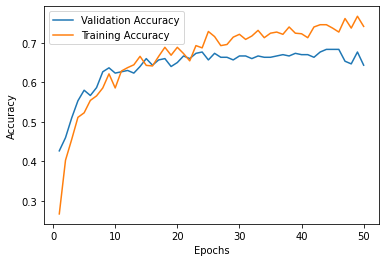

In [25]:
epochs = range(1, len(histories['q1_history'].history['accuracy'])+1)

plt.plot(epochs, histories['q1_history'].history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, histories['q1_history'].history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Accuracy stabilises as loss values reaches convergence

## Q1.C

Plot the losses on training and test data against training epochs. State the
approximate number of epochs where the test error begins to converge.

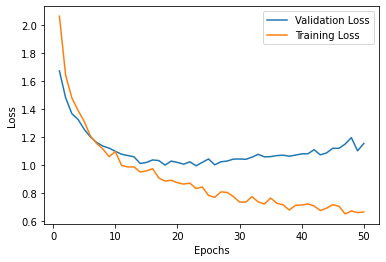

In [26]:
epochs = range(1, len(histories['q1_history'].history['loss'])+1)

plt.plot(epochs, histories['q1_history'].history['val_loss'], label='Validation Loss')
plt.plot(epochs, histories['q1_history'].history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Convergence happens at approximately 48 epochs

# Q2

In this question, we will compare the performance of the model using stochastic gradient
descent and mini-batch gradient descent, as well as determining the optimal batch size
for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient
descent by training the neural network and evaluating the performances for different
batch sizes. Note: Use 3-fold cross-validation on training partition to perform parameter
selection.

## Q2.a

Plot mean cross-validation accuracies over the training epochs for different
batch sizes. Limit search space to batch sizes {1,4,8,16,32, 64}.

In [28]:
batch_sizes = [1,4,8,16,32, 64]
kfold = KFold(n_splits = 3, shuffle = True)

kfold_input = np.concatenate((X_train, X_test), axis = 0)
kfold_target = np.concatenate((Y_train, Y_test), axis = 0)

time_tracker = {}
history_list = []

fold = 1
for train, test in kfold.split(kfold_input,  kfold_target):
    for batch in batch_sizes:
        histories = {}
        model = Sequential([
                Dense(16, activation='relu'),
                Dropout(rate = 0.3),
                Dense(10, activation='softmax')
            ])
        histories[f'q2_batch{batch}_fold{fold}'], time_tracker[f'q2_batch{batch}_fold{fold}'] = train_model(model, batch_size = batch, x_train = kfold_input[train], y_train = kfold_target[train])
        history_list.append(histories)

    fold += 1

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


666/666 - 3s - loss: 2.2720 - ce: 2.2720 - accuracy: 0.2192 - val_loss: 1.8324 - val_ce: 1.8324 - val_accuracy: 0.3400

Epoch: 0, accuracy:0.2192,  ce:2.2720,  loss:2.2720,  val_accuracy:0.3400,  val_ce:1.8324,  val_loss:1.8324,  
.Epoch 2/50
666/666 - 2s - loss: 1.7921 - ce: 1.7921 - accuracy: 0.3453 - val_loss: 1.5049 - val_ce: 1.5049 - val_accuracy: 0.5233
.Epoch 3/50
666/666 - 2s - loss: 1.5812 - ce: 1.5812 - accuracy: 0.4520 - val_loss: 1.3456 - val_ce: 1.3456 - val_accuracy: 0.5800
.Epoch 4/50
666/666 - 2s - loss: 1.4821 - ce: 1.4821 - accuracy: 0.4505 - val_loss: 1.2260 - val_ce: 1.2260 - val_accuracy: 0.5933
.Epoch 5/50
666/666 - 2s - loss: 1.3845 - ce: 1.3845 - accuracy: 0.5015 - val_loss: 1.1527 - val_ce: 1.1527 - val_accuracy: 0.6167
.Epoch 6/50
666/666 - 2s - loss: 1.3229 - ce: 1.3229 - accuracy: 0.5150 - val_loss: 1.0726 - val_ce: 1.0726 - val_accuracy: 0.6433
.Epoch 7/50
666/666 - 2s - loss: 1.2632 - ce: 1.2632 - accuracy: 0.5465 - val_loss: 1.0348 - val_ce: 1.0348 - val_

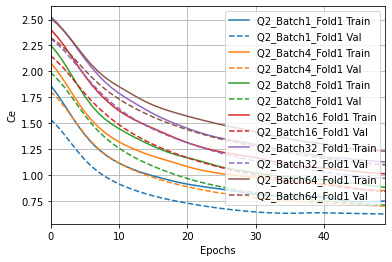

In [29]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'ce', smoothing_std=10)
# fold 1
plotter.plot(history_list[0])
plotter.plot(history_list[1])
plotter.plot(history_list[2])
plotter.plot(history_list[3])
plotter.plot(history_list[4])
plotter.plot(history_list[5])


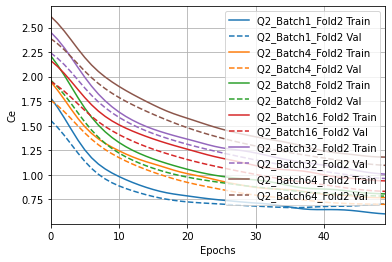

In [30]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'ce', smoothing_std=10)
# fold 2
plotter.plot(history_list[6])
plotter.plot(history_list[7])
plotter.plot(history_list[8])
plotter.plot(history_list[9])
plotter.plot(history_list[10])
plotter.plot(history_list[11])


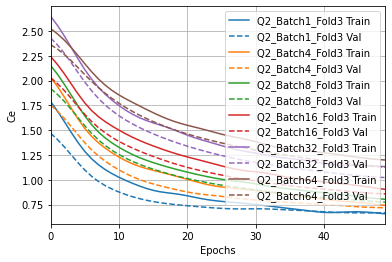

In [31]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'ce', smoothing_std=10)
# fold 3
plotter.plot(history_list[12])
plotter.plot(history_list[13])
plotter.plot(history_list[14])
plotter.plot(history_list[15])
plotter.plot(history_list[16])
plotter.plot(history_list[17])


From the results across the 3 folds we can see that batches 1, 4 and 8 results in lower cross-entropy losses. We can take a closer look individually among them.

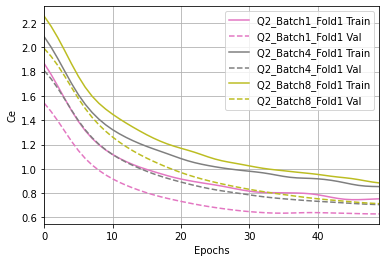

In [32]:
# fold 1
plotter.plot(history_list[0])
plotter.plot(history_list[1])
plotter.plot(history_list[2])

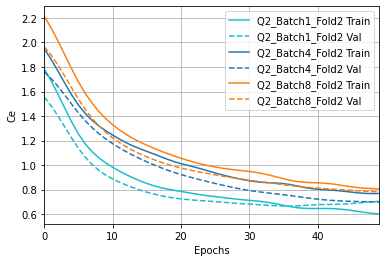

In [33]:
# fold 2
plotter.plot(history_list[6])
plotter.plot(history_list[7])
plotter.plot(history_list[8])

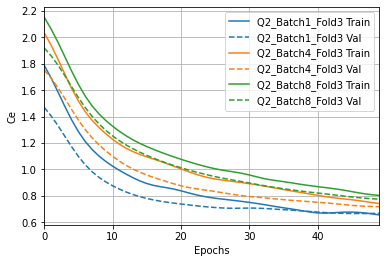

In [34]:
# fold 3
plotter.plot(history_list[12])
plotter.plot(history_list[13])
plotter.plot(history_list[14])

Batch 1 seems to produce a lower cross-entropy loss in general over time.

## Q2b. Create a table of median time

In [35]:
for time in time_tracker:
  print(f'{time}: {np.average(time_tracker[time])}')

q2_batch1_fold1: 1.8970097541809081
q2_batch4_fold1: 0.5749032831192017
q2_batch8_fold1: 0.35886210918426514
q2_batch16_fold1: 0.19689630031585692
q2_batch32_fold1: 0.12824022769927979
q2_batch64_fold1: 0.083609938621521
q2_batch1_fold2: 1.8561452341079712
q2_batch4_fold2: 0.578637285232544
q2_batch8_fold2: 0.369747896194458
q2_batch16_fold2: 0.19864710807800293
q2_batch32_fold2: 0.13557165145874023
q2_batch64_fold2: 0.09447947978973388
q2_batch1_fold3: 1.854645185470581
q2_batch4_fold3: 0.5772213935852051
q2_batch8_fold3: 0.35766672134399413
q2_batch16_fold3: 0.20206161975860595
q2_batch32_fold3: 0.1306525945663452
q2_batch64_fold3: 0.08699387073516845


## Q2.c Select optimal batch size

Use batch 8. To determine the optimal batch size we need to consider the trianing time and cross-entropy tradeoff. Out of the 3 batch sizes with the best cross-entropy loss, batch 8 has the fastest training time.

## Q2.d What is the difference between mini-batch gradient descent and stochastic gradient descent and what does this mean for model training?

In mini-batch gradient descent, training is performed on a subset batch of training patterns where as in stochastic gradient descent, every single pattern of training data is trained. The implications on the model will be its accuracy and training time. By performing training on a group of training patterns the training process is faster as it will take lesser iterations to cover all training patterns. On the other hand, training on every single patterns individually naturally leads to longer time taken. However, accuracy would be higher is every single training pattern is taken into account. Thus it is essential to balance between the tradeoff of batch size and accuracy score.

## Q2.d  Plot the train and test accuracies against epochs for the optimal batch size. 



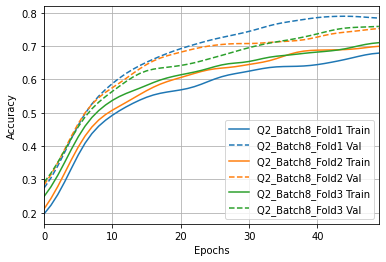

In [36]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(history_list[2])
plotter.plot(history_list[8])
plotter.plot(history_list[14])

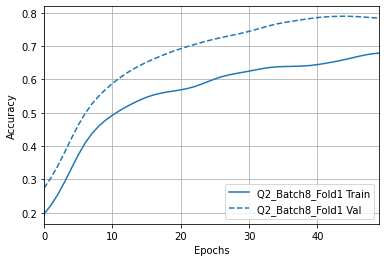

In [37]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(history_list[2])

Across the 3 folds, validation accuracy is higher than training accuracy signifying that model has generalized fine. Fold 1 produced the highest accuracy as such, the model can be said to be the more optimal.

# Q3 Find the optimal number of hidden neurons for the 2-layer network (i.e., one hidden layer) designed in Question 1 and 2.

## Q3.a Plot the cross-validation accuracies against training epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {8, 16, 32, 64}. Continue using 3-fold cross validation on training dataset.

In [40]:
no_of_neuron = [8, 16, 32, 64]
batch_size = 8 # selected optimal batch size
kfold = KFold(n_splits = 3, shuffle = True)

kfold_input = np.concatenate((X_train, X_test), axis = 0)
kfold_target = np.concatenate((Y_train, Y_test), axis = 0)

time_tracker = {}
history_list = []

fold = 1
for train, test in kfold.split(kfold_input,  kfold_target):
    for neuron in no_of_neuron:
        histories = {}
        model = Sequential([
                Dense(neuron, activation='relu'),
                Dropout(rate = 0.3),
                Dense(10, activation='softmax')
            ])
        histories[f'q2_neurons{neuron}_fold{fold}'], time_tracker[f'q2_neurons{neuron}_fold{fold}'] = train_model(model, batch_size = batch_size, x_train = kfold_input[train], y_train = kfold_target[train])
        history_list.append(histories)

    fold += 1

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


84/84 - 2s - loss: 2.4122 - ce: 2.4030 - accuracy: 0.1381 - val_loss: 2.1952 - val_ce: 2.2042 - val_accuracy: 0.1700

Epoch: 0, accuracy:0.1381,  ce:2.4030,  loss:2.4122,  val_accuracy:0.1700,  val_ce:2.2042,  val_loss:2.1952,  
.Epoch 2/50
84/84 - 0s - loss: 2.2042 - ce: 2.2039 - accuracy: 0.1892 - val_loss: 2.0536 - val_ce: 2.0624 - val_accuracy: 0.2333
.Epoch 3/50
84/84 - 0s - loss: 2.0821 - ce: 2.0754 - accuracy: 0.2207 - val_loss: 1.9397 - val_ce: 1.9482 - val_accuracy: 0.3300
.Epoch 4/50
84/84 - 0s - loss: 1.9738 - ce: 1.9727 - accuracy: 0.2778 - val_loss: 1.8475 - val_ce: 1.8551 - val_accuracy: 0.3833
.Epoch 5/50
84/84 - 0s - loss: 1.9180 - ce: 1.9138 - accuracy: 0.3003 - val_loss: 1.7723 - val_ce: 1.7798 - val_accuracy: 0.4300
.Epoch 6/50
84/84 - 0s - loss: 1.8094 - ce: 1.8112 - accuracy: 0.3589 - val_loss: 1.7025 - val_ce: 1.7098 - val_accuracy: 0.4400
.Epoch 7/50
84/84 - 0s - loss: 1.7630 - ce: 1.7631 - accuracy: 0.3559 - val_loss: 1.6491 - val_ce: 1.6556 - val_accuracy: 0.44

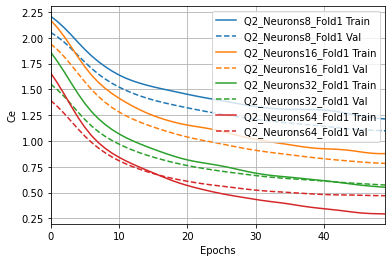

In [41]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'ce', smoothing_std=10)
# fold 1
plotter.plot(history_list[0])
plotter.plot(history_list[1])
plotter.plot(history_list[2])
plotter.plot(history_list[3])

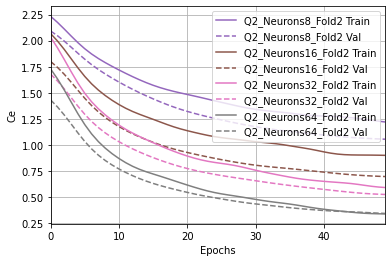

In [42]:
# fold 2
plotter.plot(history_list[4])
plotter.plot(history_list[5])
plotter.plot(history_list[6])
plotter.plot(history_list[7])

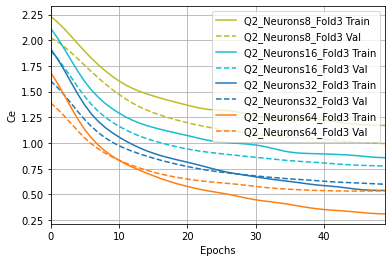

In [43]:
# fold 3
plotter.plot(history_list[8])
plotter.plot(history_list[9])
plotter.plot(history_list[10])
plotter.plot(history_list[11])

## Q3.b Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

64 Neuronns. Training cross-entropy should be lower as it approaches convergence since it is suppose to perform better.

## Q3.c Plot the train and test accuracies against training epochs with the optimal number of neurons.

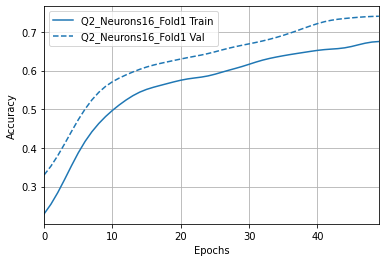

In [44]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(history_list[1])

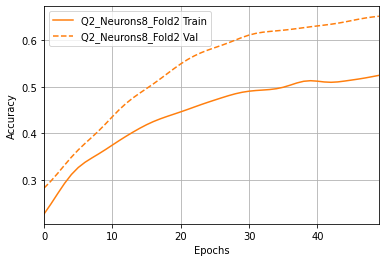

In [45]:
plotter.plot(history_list[4])

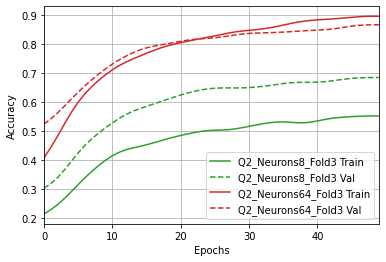

In [48]:
plotter.plot(history_list[8])
plotter.plot(history_list[11])

## Q3.d What other parameters could possibly be tuned? 

Learning rate, dropout rate, optimizer, number of epochs.

# Q4 After you are done with the 2-layer network, design a 3-layer network with two hiddenlayers with ReLU activation, each consisting of the optimal number of neurons you obtained in Question 3, (apply a dropout with a probability of 0.3 for each hidden layer), and train it with a batch size of 1.

## Q4.a  Plot the train and test accuracy of the 3-layer network against training epochs.

In [31]:
batch_size = 1 # selected optimal batch size
neuron = 64 # selected optimal no. of neurons
models = [
        Sequential([
            Dense(neuron, activation='relu'),
            Dropout(rate = 0.3),
            Dense(10, activation='softmax')
        ]),
        Sequential([
            Dense(neuron, activation='relu'),
            Dropout(rate = 0.3),
            Dense(neuron, activation='relu'),
            Dropout(rate = 0.3),
            Dense(10, activation='softmax')
        ])
      ]

kfold = KFold(n_splits = 3, shuffle = True)
kfold_input = np.concatenate((X_train, X_test), axis = 0)
kfold_target = np.concatenate((Y_train, Y_test), axis = 0)

time_tracker = {}
history_list = []

fold = 1
for train, test in kfold.split(kfold_input,  kfold_target):
    j = 2
    for model in models:
        histories = {}
        histories[f'q2_layers{j}_fold{fold}'], time_tracker[f'q2_neurons{neuron}_fold{fold}'] = train_model(model, batch_size = batch_size, x_train = kfold_input[train], y_train = kfold_target[train])
        history_list.append(histories)
        j+=1

    fold += 1

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


21/21 - 1s - loss: 2.5709 - categorical_crossentropy: 2.5706 - accuracy: 0.1682 - ce: 2.5709 - val_loss: 2.0214 - val_categorical_crossentropy: 2.0219 - val_accuracy: 0.3067 - val_ce: 2.0214

Epoch: 0, accuracy:0.1682,  categorical_crossentropy:2.5706,  ce:2.5709,  loss:2.5709,  val_accuracy:0.3067,  val_categorical_crossentropy:2.0219,  val_ce:2.0214,  val_loss:2.0214,  
.Epoch 2/50
21/21 - 0s - loss: 1.9890 - categorical_crossentropy: 1.9876 - accuracy: 0.2958 - ce: 1.9890 - val_loss: 1.6784 - val_categorical_crossentropy: 1.6767 - val_accuracy: 0.4100 - val_ce: 1.6784
.Epoch 3/50
21/21 - 0s - loss: 1.6655 - categorical_crossentropy: 1.6642 - accuracy: 0.4009 - ce: 1.6655 - val_loss: 1.4994 - val_categorical_crossentropy: 1.4986 - val_accuracy: 0.4967 - val_ce: 1.4994
.Epoch 4/50
21/21 - 0s - loss: 1.5483 - categorical_crossentropy: 1.5490 - accuracy: 0.4399 - ce: 1.5483 - val_loss: 1.3801 - val_categorical_crossentropy: 1.3792 - val_accuracy: 0.5533 - val_ce: 1.3801
.Epoch 5/50
21/2

## Q4.b Compare and comment on the performances of the optimal 2-layer network from your hyperparameter tuning in Question 2 and 3 and the 3-layer network

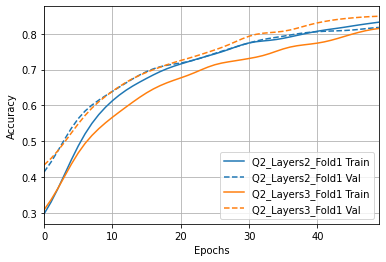

In [32]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)

# fold 1
plotter.plot(history_list[0])
plotter.plot(history_list[1])

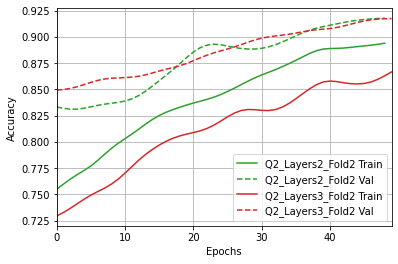

In [33]:
# fold 2
plotter.plot(history_list[2])
plotter.plot(history_list[3])

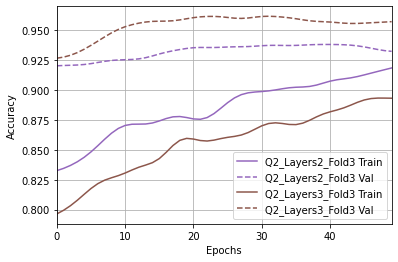

In [34]:
# fold 3
plotter.plot(history_list[4])
plotter.plot(history_list[5])

It can be seen that a 3 layer network generally outperforms a 2 layer network in terms of its accuracy. A reason for this is that a 3 layer network is able to learn more parameters as opposed to a 2 layer network.

# Q5 We are going to dissect the purpose of dropout in the model

## Q5.a Why do we add dropouts? Investigate the purpose of dropouts by removing dropouts from your original 2-layer network (before changing the batch size and number of neurons). Plot accuracies on training and test data with neural network without dropout. Plot as well the losses on training and test data with neural network without dropout.

Dropout prevent neuron units from interdependnce by ignoring subset of units using a set probability.

In [ ]:
# plot network with and without dropouts

## Q5.b Explain the effect of removing dropouts

Model may overfit without implmenting dropouts.

## Q5.c What is another approach that you could take to address overfitting in the model?

Possible techniques to address overfitting:


*   L1/L2 regularization: Punishes network from learning overly-complicated model
*   Learn the more significant features

*   Image augmentation (more for image classification than current task)



